# Imports and Global Variables

## Imports

In [22]:
import os
import sys
import hashlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import random
from PIL import Image, ImageOps

## Global Variables

### Directories

In [23]:
test_dir = "../data/chest_xray/test"
train_dir = "../data/chest_xray/train"

### Parameters

In [24]:
RANDOM_SEED = 42

# Utility Functions

In [25]:
def create_dataframe(directory, dataset_type):
    data = []
    
    # Iterate through normal and pneumonia folders
    for label in ['NORMAL', 'PNEUMONIA']:
        folder_path = directory +"/" +label
        if os.path.exists(folder_path):
            for img_file in os.scandir(folder_path):
                if img_file.is_file() and (img_file.name.endswith('.jpeg') or img_file.name.endswith('.jpg') or img_file.name.endswith('.png')):
                    data.append({
                        'image_name': img_file.name,
                        'image_path': folder_path + "/" + img_file.name,
                        'has_pneumonia': 1 if label == 'PNEUMONIA' else 0,
                        'dataset': dataset_type
                    })
    
    return pd.DataFrame(data)


def exif_transpose(im):
    try:
        return ImageOps.exif_transpose(im)
    except Exception:
        return im
    
def pick_sample(df, n=None):
    if n is None or n >= len(df):
        return df
    return df.sample(n=n, random_state=RANDOM_SEED)

def safe_open(path):
    try:
        im = Image.open(path)
        im.load()
        return im
    except Exception:
        return None

def image_stats(im):
    im = exif_transpose(im)
    if im.mode not in ("RGB", "L"):
        im = im.convert("RGB")
    arr = np.asarray(im)
    if arr.ndim == 2:  # L
        arr = arr.astype(np.float32) / 255.0
        return {
            "mode": "L",
            "w": im.width, "h": im.height,
            "aspect": im.width / im.height,
            "min": float(arr.min()), "max": float(arr.max()),
            "mean": float(arr.mean()), "std": float(arr.std()),
        }
    else:
        arr = arr.astype(np.float32) / 255.0
        flat = arr.reshape(-1, 3)
        return {
            "mode": "RGB",
            "w": im.width, "h": im.height,
            "aspect": im.width / im.height,
            "min": [float(flat[:,0].min()), float(flat[:,1].min()), float(flat[:,2].min())],
            "max": [float(flat[:,0].max()), float(flat[:,1].max()), float(flat[:,2].max())],
            "mean": [float(flat[:,0].mean()), float(flat[:,1].mean()), float(flat[:,2].mean())],
            "std": [float(flat[:,0].std()), float(flat[:,1].std()), float(flat[:,2].std())],
        }
    
def file_sha256(path, block=1 << 20):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        while True:
            b = f.read(block)
            if not b: break
            h.update(b)
    return h.hexdigest()

def image_phash(im, hash_size=16):
    # Simple phash without external deps
    # 1) convert to L, resize larger, DCT, take low-freq block
    from scipy.fftpack import dct
    im = exif_transpose(im).convert("L").resize((hash_size*4, hash_size*4), Image.BILINEAR)
    arr = np.asarray(im).astype(np.float32)
    d = dct(dct(arr, axis=0, norm='ortho'), axis=1, norm='ortho')
    d_low = d[:hash_size, :hash_size]
    med = np.median(d_low)
    bits = (d_low > med).astype(np.uint8).flatten()
    # pack bits into hex string
    # (not the most compact, but fine for grouping)
    return ''.join(map(str, bits.tolist()))

# Splitting Train and Test Data

In [26]:
train_df = create_dataframe(train_dir, 'train')
test_df = create_dataframe(test_dir, 'test')

In [27]:
#export dataframes to csv
train_df.to_csv('../data/chest_xray/train/train_labels.csv', index=False)
test_df.to_csv('../data/chest_xray/test/test_labels.csv', index=False)

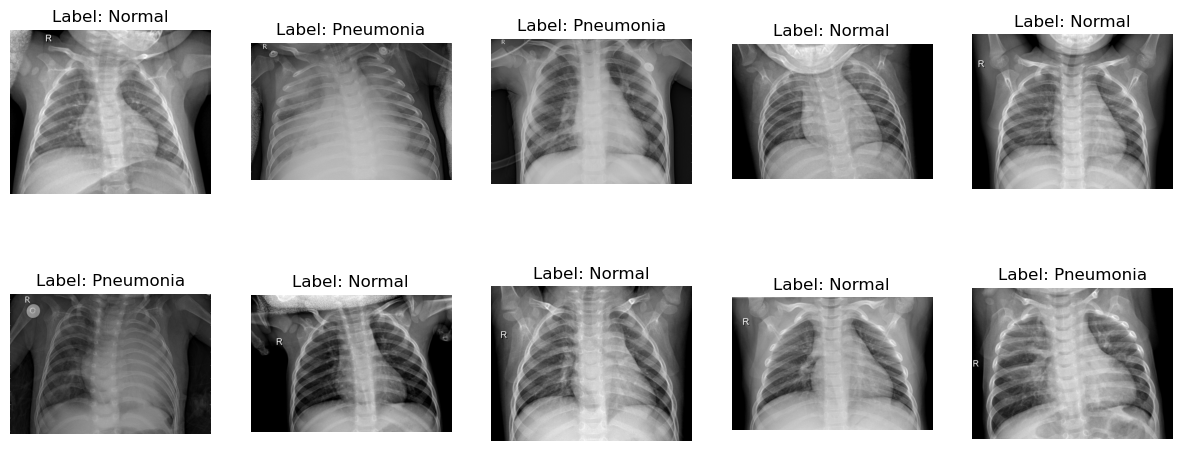

In [28]:
#randomly grab 10 samples from train and display
sampled_df = train_df.sample(n=10, random_state=42).reset_index(drop=True)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    img = Image.open(sampled_df.loc[i, 'image_path'])
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {'Pneumonia' if sampled_df.loc[i, 'has_pneumonia'] == 1 else 'Normal'}")
    ax.axis('off')

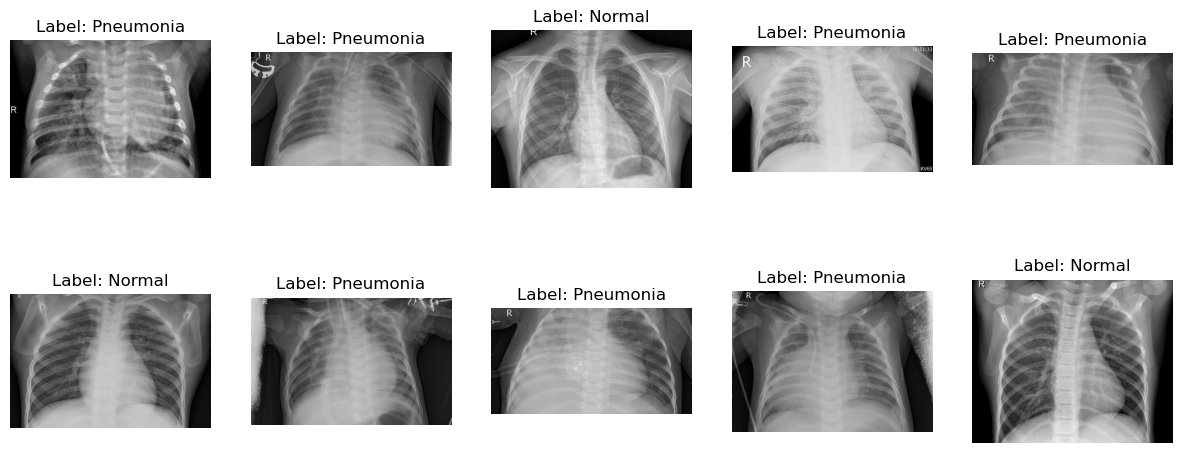

In [29]:
#randomly grab 10 samples from test and display
sampled_df = test_df.sample(n=10, random_state=42).reset_index(drop=True)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    img = Image.open(sampled_df.loc[i, 'image_path'])
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {'Pneumonia' if sampled_df.loc[i, 'has_pneumonia'] == 1 else 'Normal'}")
    ax.axis('off')

In [30]:
train_df.head()

,image_name,image_path,has_pneumonia,dataset
0,IM-0115-0001.jpeg,../data/chest_xray/train/NORMAL/IM-0115-0001.jpeg,0,train
1,IM-0117-0001.jpeg,../data/chest_xray/train/NORMAL/IM-0117-0001.jpeg,0,train
2,IM-0119-0001.jpeg,../data/chest_xray/train/NORMAL/IM-0119-0001.jpeg,0,train
3,IM-0122-0001.jpeg,../data/chest_xray/train/NORMAL/IM-0122-0001.jpeg,0,train
4,IM-0125-0001.jpeg,../data/chest_xray/train/NORMAL/IM-0125-0001.jpeg,0,train


In [31]:
test_df.head()

,image_name,image_path,has_pneumonia,dataset
0,IM-0001-0001.jpeg,../data/chest_xray/test/NORMAL/IM-0001-0001.jpeg,0,test
1,IM-0003-0001.jpeg,../data/chest_xray/test/NORMAL/IM-0003-0001.jpeg,0,test
2,IM-0005-0001.jpeg,../data/chest_xray/test/NORMAL/IM-0005-0001.jpeg,0,test
3,IM-0006-0001.jpeg,../data/chest_xray/test/NORMAL/IM-0006-0001.jpeg,0,test
4,IM-0007-0001.jpeg,../data/chest_xray/test/NORMAL/IM-0007-0001.jpeg,0,test


# Exploratory Data Analysis

## Class balance

<Axes: xlabel='has_pneumonia'>

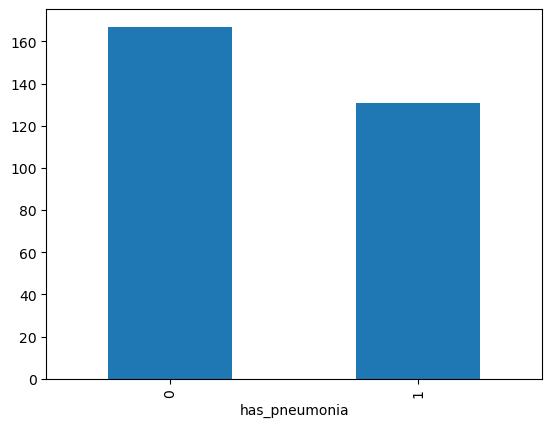

In [32]:
train_df['has_pneumonia'].value_counts().plot(kind='bar')

<Axes: xlabel='has_pneumonia'>

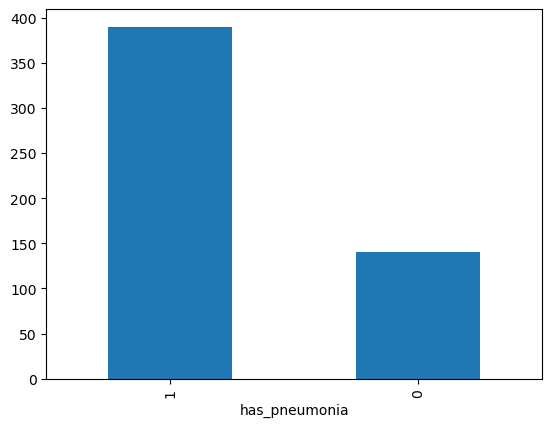

In [33]:
test_df['has_pneumonia'].value_counts().plot(kind='bar')

## Image Characteristics

In [34]:
# size and mode statistics for train dataset
size_stats = []
failed_images = []

print(f"Total train images: {len(train_df)}")

for idx, row in train_df.iterrows():
    img = safe_open(row['image_path'])
    if img is not None:
        stats = image_stats(img)
        stats.update({'image_name': row['image_name'], 'dataset': 'train'})
        size_stats.append(stats)
    else:
        failed_images.append(row['image_name'])

print(f"\nSuccessfully processed: {len(size_stats)} images")
print(f"Failed to open: {len(failed_images)} images")

if failed_images:
    print(f"\nFirst 10 failed images:")
    print(failed_images[:10])
    
    # Check if paths exist
    sample_failed = train_df[train_df['image_name'] == failed_images[0]]['image_path'].iloc[0]
    print(f"\nChecking first failed path exists: {os.path.exists(sample_failed)}")
    print(f"Path: {sample_failed}")

print(f"\nFirst 5 successful stats:")
print(size_stats[:5])

Total train images: 298

Successfully processed: 298 images
Failed to open: 0 images

First 5 successful stats:
[{'mode': 'L', 'w': 2090, 'h': 1858, 'aspect': 1.1248654467169, 'min': 0.0, 'max': 1.0, 'mean': 0.5055195093154907, 'std': 0.24431777000427246, 'image_name': 'IM-0115-0001.jpeg', 'dataset': 'train'}, {'mode': 'L', 'w': 1422, 'h': 1152, 'aspect': 1.234375, 'min': 0.0, 'max': 1.0, 'mean': 0.3947083055973053, 'std': 0.23454254865646362, 'image_name': 'IM-0117-0001.jpeg', 'dataset': 'train'}, {'mode': 'L', 'w': 1810, 'h': 1434, 'aspect': 1.2622036262203626, 'min': 0.0, 'max': 1.0, 'mean': 0.4783197343349457, 'std': 0.27002522349357605, 'image_name': 'IM-0119-0001.jpeg', 'dataset': 'train'}, {'mode': 'L', 'w': 1618, 'h': 1279, 'aspect': 1.2650508209538702, 'min': 0.0, 'max': 1.0, 'mean': 0.5215145349502563, 'std': 0.2547869086265564, 'image_name': 'IM-0122-0001.jpeg', 'dataset': 'train'}, {'mode': 'L', 'w': 1600, 'h': 1125, 'aspect': 1.4222222222222223, 'min': 0.0, 'max': 1.0, 'me

In [38]:
print(np.asarray(stds).shape)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (298,) + inhomogeneous part.

In [39]:
# histogram of image stats for train dataset
widths = [stat['w'] for stat in size_stats]
heights = [stat['h'] for stat in size_stats]

# Handle potentially multi-dimensional stats (for multi-channel images)
stds = []
means = []
modes = []

for stat in size_stats:
    # Convert to scalar if array (take mean across channels if needed)
    std_val = stat['std']
    stds.append(np.mean(std_val) if isinstance(std_val, list) else std_val)
    
    mean_val = stat['mean']
    means.append(np.mean(mean_val) if isinstance(mean_val, list) else mean_val)
    
    mode_val = stat['mode']
    if hasattr(mode_val, 'mode'):
        modes.append(np.mean(mode_val.mode))
    elif isinstance(mode_val, list):
        modes.append(np.mean(mode_val))
    else:
        modes.append(mode_val)

widths = np.array(widths)
heights = np.array(heights)
stds = np.array(stds)
means = np.array(means)
modes = np.array(modes)

Text(0.5, 1.0, 'Image Standard Deviation Pixel Values')

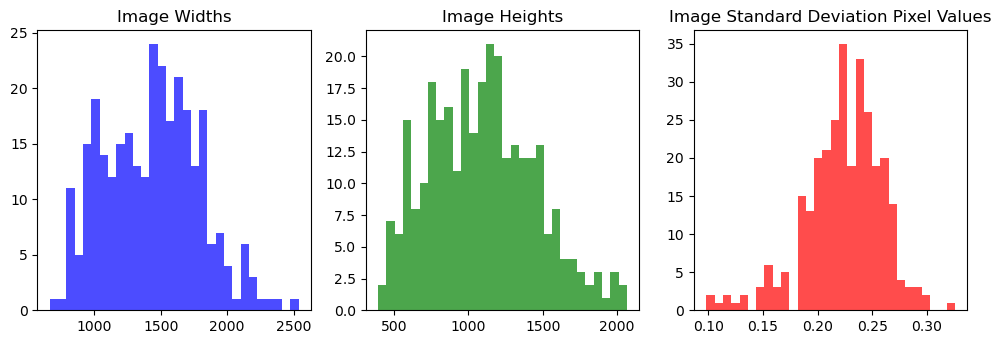

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.hist(widths, bins=30, color='blue', alpha=0.7)
plt.title('Image Widths')

plt.subplot(2, 3, 2)
plt.hist(heights, bins=30, color='green', alpha=0.7)
plt.title('Image Heights')

plt.subplot(2, 3, 3)
plt.hist(stds, bins=30, color='red', alpha=0.7)
plt.title('Image Standard Deviation Pixel Values')

plt.subplot(2, 3, 4)
plt.hist(means, bins=30, color='orange', alpha=0.7)
plt.title('Image Mean Pixel Values')

plt.subplot(2, 3, 5)
plt.hist(modes, bins=30, color='purple', alpha=0.7)
plt.title('Image Mode Pixel Values')